<a href="https://colab.research.google.com/github/pedrojosefernandez1/RL_FCPSSL/blob/main/MetodosTabulares.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudio del Comportamiento de Algoritmos de Aprendizaje por Refuerzo por Métodos Tabulares

````
Author: Jaime Pujante Sáez
Email: jaime.pujantes@um.es

Author: Ricardo Javier Sendra Lázaro
Email: ricardojavier.sendral@um.es

Author: Pedro José Fernandez Campillo
Email: pedrojose.fernandez1@um.es
````

En este notebook, se analizará el comportamiento de distintos algoritmos de aprendizaje por refuerzo basados en métodos tabulares, tales como:
- **MonteCarlo**
- **SARSA**
- **Q-Learning**

El objetivo es evaluar su desempeño en un entorno del framework **Gymnasium**.
## Preparación del entorno
### 1. Clonación del repositorio e instalación de dependencias
Para comenzar, clonamos el repositorio con la implementación de los algoritmos y luego instalamos las dependencias necesarias:


In [1]:
import os
from urllib.parse import urlparse

GITHUB_REPO_URL = "https://github.com/pedrojosefernandez1/RL_FCPSSL.git"
# Extraer usuario y nombre del repositorio automáticamente
def obtener_usuario_y_repo(url):
    path = urlparse(url).path.strip('/')
    parts = path.split('/')
    if len(parts) >= 2:
        return parts[0], parts[1]
    return None, None

GITHUB_USERNAME, GITHUB_REPO_NAME = obtener_usuario_y_repo(GITHUB_REPO_URL)
GITHUB_REPO_NAME = GITHUB_REPO_NAME.replace('.git', '')
if not GITHUB_USERNAME or not GITHUB_REPO_NAME:
    raise ValueError("URL del repositorio inválida. Asegúrate de que sea de GitHub y tenga el formato correcto.")

REPO_NAME = GITHUB_REPO_NAME  # Nombre de la carpeta después de clonar

# Clonar el repositorio si no existe
os.makedirs(REPO_NAME, exist_ok=True)
if not os.path.exists(os.path.join(REPO_NAME, ".git")):
    ! git clone {GITHUB_REPO_URL} {REPO_NAME}

# Verificar si existe un archivo requirements.txt para instalar dependencias
req_file = os.path.join(REPO_NAME, "requirements.txt")
if os.path.exists(req_file):
    ! pip install -r {req_file}

### 2. Importación de librerías necesarias
Una vez instaladas las dependencias, importamos las librerías requeridas para el análisis:

In [2]:
import os
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import numpy as np
from tqdm import tqdm
import sys

SEED = 32

np.random.seed(SEED) # Para generar números aleatorios consistentes en NumPy
np.random.default_rng(SEED) # Establece una instancia del generador de NumPy con la misma semilla

os.environ['PYTHONHASHSEED'] = str(SEED)

In [3]:
try:
  sys.path.append(f'src')
  print(sys.path)
  from plotting import plot_episode_rewards, plot_episode_proporcional_rewards, plot_len_episodes, render_episode, show_images_grid, plot_episode_rewards_subplot, plot_len_episodes_subplot
  from agents import MonteCarloEpsilonGreedyAgent, SarsaEpsilonGreedyAgent, QLearningEpsilonGreedyAgent

except:
  sys.path.append(f'{REPO_NAME}/src')
  print(sys.path)
  from plotting import plot_episode_rewards, plot_episode_proporcional_rewards, plot_len_episodes, render_episode, show_images_grid, plot_episode_rewards_subplot, plot_len_episodes_subplot
  from agents import MonteCarloEpsilonGreedyAgent, SarsaEpsilonGreedyAgent, QLearningEpsilonGreedyAgent

['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', 'src']
['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', 'src', 'RL_FCPSSL/src']


## Estudio de los distintos algoritmos tabulares

In [4]:
N_EPISODES = 25000

env_frozen_lake = gym.make('FrozenLake-v1',
                           is_slippery=False,
                           map_name="4x4",
                           render_mode="rgb_array",
                           max_episode_steps=500)

env_taxi = gym.make('Taxi-v3',
                    render_mode="rgb_array",
                    max_episode_steps=500)


### MonteCarlo

In [5]:
# Definir los valores de epsilon
epsilon_values = [0.7, 0.3]

# Definir los entornos y sus nombres
environments = {
    "FrozenLake": env_frozen_lake,
    "Taxi": env_taxi
}

agents_info = []

for env_name, env in environments.items():
    for epsilon in epsilon_values:
        agent = MonteCarloEpsilonGreedyAgent(env, epsilon=epsilon, epsilon_decay=1)
        agents_info.append({
            "agent": agent,
            "environment": env_name,
            "epsilon": epsilon
        })

# Entrenar a los agentes y registrar estadísticas
stats_list = []

for info in agents_info:
    agent = info["agent"]
    agent.train(N_EPISODES, render_interval=500, video_path='videos')

    # Guardar estadísticas con el metadata asociado
    stats_list.append({
        "environment": info["environment"],
        "epsilon": info["epsilon"],
        "stats": agent.stats()
    })
del agents_info

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos/FrozenLake-v1/MonteCarloEpsilonGreedyAgent(gamma0.99_epsilon0.7_epsilon_decay1_min_epsilon0.01) folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
100%|██████████| 25000/25000 [00:21<00:00, 1144.30it/s]
/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos/FrozenLake-v1/MonteCarloEpsilonGreedyAgent(gamma0.99_epsilon0.3_epsilon_decay1_min_epsilon0.01) folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
100%|██████████| 25000/25000 [00:25<00:00, 988.63it/s] 
/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos/Taxi-v3/MonteCarloEpsilonGree

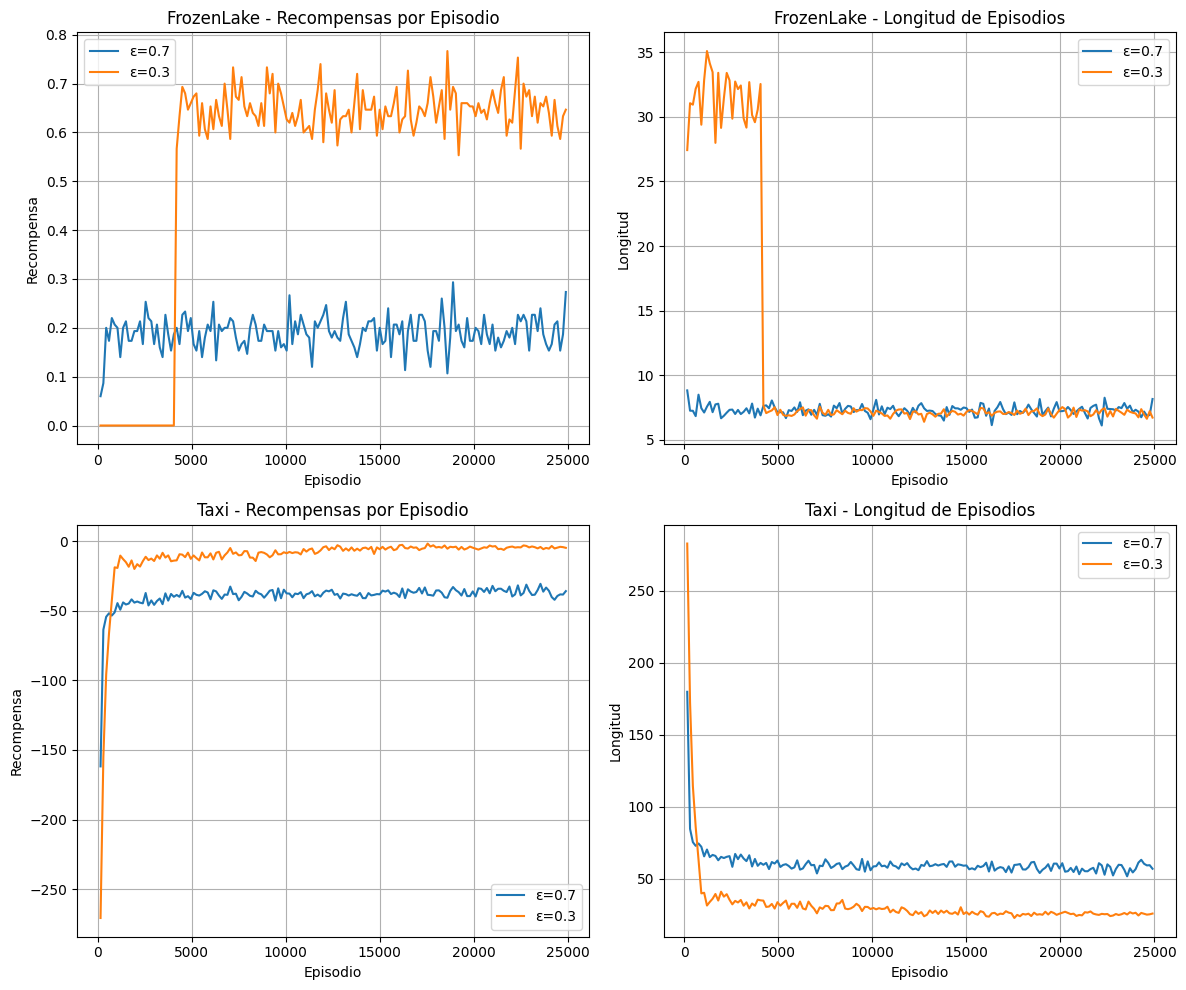

In [6]:
import matplotlib.pyplot as plt

n_media=150

# Agrupar estadísticas por environment
env_stats = {}
for entry in stats_list:
    env_name = entry["environment"]
    if env_name not in env_stats:
        env_stats[env_name] = []
    env_stats[env_name].append(entry)  # Guardamos todas las configuraciones de epsilon/alpha

# Crear subplots dinámicos según el número de entornos
num_envs = len(env_stats)
fig, axes = plt.subplots(num_envs, 2, figsize=(12, 5 * num_envs))  # (filas, columnas)

# Si solo hay un entorno, convertir `axes` en una lista para evitar errores de indexación
if num_envs == 1:
    axes = [axes]

# Generar gráficos por cada entorno
for idx, (env_name, env_entries) in enumerate(env_stats.items()):
    ax1, ax2 = axes[idx]  # Obtener los ejes de la fila correspondiente

    # Primera columna: Recompensas por episodio
    plt.sca(ax1)  # Establecer el eje activo en ax1
    for entry in env_entries:
        label = f"ε={entry['epsilon']}"
        plot_episode_rewards_subplot(entry["stats"]["episode_rewards"], n_media=n_media, ax=ax1)  # Usar tu función
    ax1.set_title(f"{env_name} - Recompensas por Episodio")
    ax1.set_xlabel("Episodio")
    ax1.set_ylabel("Recompensa")
    ax1.legend([f"ε={e['epsilon']}" for e in env_entries])  # Leyenda con α y ε

    # Segunda columna: Longitud de episodios
    plt.sca(ax2)  # Establecer el eje activo en ax2
    for entry in env_entries:
        plot_len_episodes_subplot(entry["stats"]["episodes"], n_media=n_media, ax=ax2)  # Usar tu función
    ax2.set_title(f"{env_name} - Longitud de Episodios")
    ax2.set_xlabel("Episodio")
    ax2.set_ylabel("Longitud")
    ax2.legend([f"ε={e['epsilon']}" for e in env_entries])  # Leyenda con α y ε

# Ajustar el espacio entre subplots
plt.tight_layout()
plt.show()


#### Análisis de los Resultados en Taxi y FrozenLake
Este experimento usa un agente basado en `Monte Carlo` con una política epsilon-greedy para aprender en los entornos Taxi y FrozenLake de Gymnasium. Se comparan diferentes valores de epsilon (ε), que controla cuánto explora el agente antes de tomar decisiones basadas en lo que ya ha aprendido.

##### Entorno Taxi

##### Recompensas por episodio

- En este entorno, lo ideal es que la recompensa promedio se acerque a 0.
Al inicio, el agente con `ε=0.7` obtiene recompensas más negativas, lo que indica que explora más antes de mejorar. En cambio, con `ε=0.3`, el aprendizaje es más rápido y las recompensas suben antes.

##### Longitud de episodios

- Al principio, los episodios son largos, pero a medida que el agente aprende, se van acortando.
Con `ε=0.3`, los episodios se vuelven más cortos más rápido, lo que significa que el agente está encontrando la mejor forma de completar la tarea sin dar tantas vueltas.

- El agente con `ε=0.3` parece aprender más rápido y de manera más eficiente, ya que termina los episodios en menos pasos y logra mejores recompensas en menos tiempo. En cambio, el de `ε=0.3` tarda más en estabilizarse, ya que explora demasiado al inicio.

##### Entorno FrozenLake
##### Recompensas por episodio:

- En este caso, mientras más alta la recompensa, mejor está jugando el agente.
- Con `ε=0.3`, el agente logra mejores recompensas, ya que aprendió bien cómo moverse en el lago sin caer en los agujeros.
- Con `ε=0.3`, la recompensa es más inestable, ya que el agente explora demasiado y comete más errores.

##### Longitud de episodios:

- La longitud del episodio si es mas corta no indica que sea mejor ya que puede ser mas corta en longitud pero puede que sea porque haya fallado en menos pasos. Para ello hay que verlo junto a la recompensa por episodio
- Con `ε=0.3`, los episodios duran menos y viendo la recompensa que tiene un ratio bajo, por lo que esta fallando continuamente muy rapido.
- El agente con `ε=0.3` se desempeña mejor, ya que obtiene más recompensas y resuelve los episodios en menos pasos, por lo que vemos una correlacion sobre el capitulo 5000 que aumenta el ratio de recompensas y la longitud de capitulos es menor.

Conclusión
- Un ε más alto (0.7) hace que el agente explore más, pero a veces explora de más y tarda en aprender.
- Un ε más bajo (0.3) permite que el agente aproveche mejor lo que ya aprendió, ya que logra mejores resultados más rápido.
- **Montecarlo** con `ε=0.3` parece ser la mejor opción en ambos entornos, ya que permite aprender más rápido sin explorar de más.
- Al ser una on-policy, aprende basándose en la política actual y por tanto si ε es baja rápido, el aprendizaje puede quedarse atrapado en una política subóptima.

### Sarsa

In [7]:
# Definir los valores de alpha y epsilon
alpha_values = [1, 0.7]  # Menos agresivo y más agresivo
epsilon_values = [1, 0.7]  # Menos explorador y más explorador

# Definir los entornos y sus nombres
environments = {
    "FrozenLake": env_frozen_lake,
    "Taxi": env_taxi
}

# Crear los agentes y almacenar metadatos
agents_info = []

for env_name, env in environments.items():
    for alpha in alpha_values:
        for epsilon in epsilon_values:
            agent = SarsaEpsilonGreedyAgent(
                env,
                epsilon=epsilon,
                gamma=0.99,
                alpha=alpha,
                epsilon_decay=0.9995,
                alpha_decay=0.9995,
                min_epsilon=0.001,
                min_alpha=0.001
            )
            agents_info.append({
                "agent": agent,
                "environment": env_name,
                "alpha": alpha,
                "epsilon": epsilon
            })

# Entrenar a los agentes y registrar estadísticas
stats_list = []

for info in agents_info:
    agent = info["agent"]
    agent.train(N_EPISODES, render_interval=500, video_path='videos')

    # Guardar estadísticas con el metadata asociado
    stats_list.append({
        "environment": info["environment"],
        "alpha": info["alpha"],
        "epsilon": info["epsilon"],
        "stats": agent.stats()
    })


/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos/FrozenLake-v1/SarsaEpsilonGreedyAgent(gamma0.99_alpha1_alpha_decay0.9995_min_alpha0.001_epsilon1_epsilon_decay0.9995_min_epsilon0.001) folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
100%|██████████| 25000/25000 [00:22<00:00, 1097.14it/s]
/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos/FrozenLake-v1/SarsaEpsilonGreedyAgent(gamma0.99_alpha1_alpha_decay0.9995_min_alpha0.001_epsilon0.7_epsilon_decay0.9995_min_epsilon0.001) folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
100%|██████████| 25000/25000 [12:55<00:00, 32.23it/s]
/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN

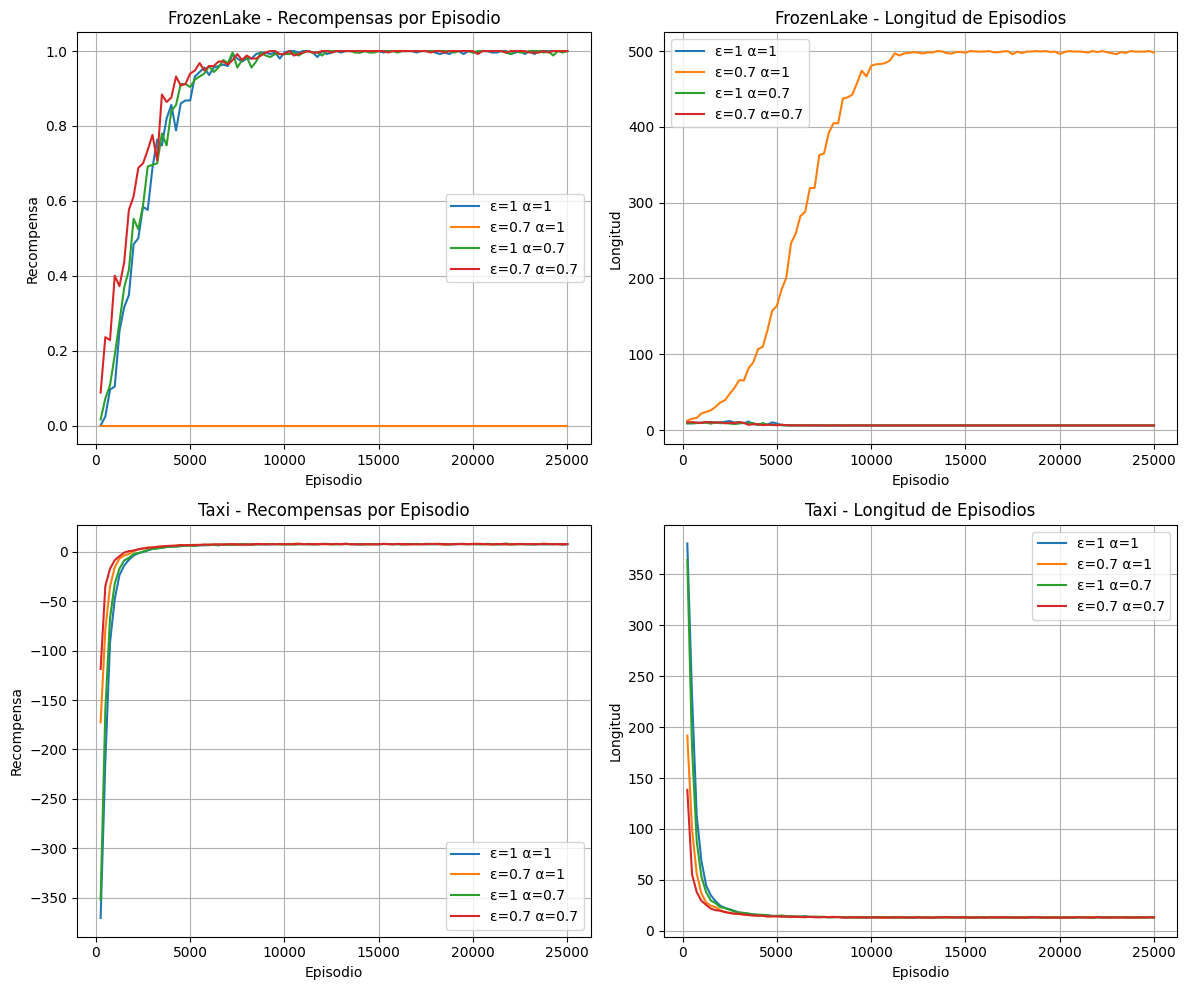

In [8]:
import matplotlib.pyplot as plt

n_media=250

# Agrupar estadísticas por environment
env_stats = {}
for entry in stats_list:
    env_name = entry["environment"]
    if env_name not in env_stats:
        env_stats[env_name] = []
    env_stats[env_name].append(entry)  # Guardamos todas las configuraciones de epsilon/alpha

# Crear subplots dinámicos según el número de entornos
num_envs = len(env_stats)
fig, axes = plt.subplots(num_envs, 2, figsize=(12, 5 * num_envs))  # (filas, columnas)

# Si solo hay un entorno, convertir `axes` en una lista para evitar errores de indexación
if num_envs == 1:
    axes = [axes]

# Generar gráficos por cada entorno
for idx, (env_name, env_entries) in enumerate(env_stats.items()):
    ax1, ax2 = axes[idx]  # Obtener los ejes de la fila correspondiente

    # Primera columna: Recompensas por episodio
    plt.sca(ax1)  # Establecer el eje activo en ax1
    for entry in env_entries:
        label = f"ε={entry['epsilon']} α={entry['alpha']}"
        plot_episode_rewards_subplot(entry["stats"]["episode_rewards"], n_media=n_media, ax=ax1)  # Usar tu función
    ax1.set_title(f"{env_name} - Recompensas por Episodio")
    ax1.set_xlabel("Episodio")
    ax1.set_ylabel("Recompensa")
    ax1.legend([f"ε={e['epsilon']} α={e['alpha']}" for e in env_entries])  # Leyenda con α y ε

    # Segunda columna: Longitud de episodios
    plt.sca(ax2)  # Establecer el eje activo en ax2
    for entry in env_entries:
        plot_len_episodes_subplot(entry["stats"]["episodes"], n_media=n_media, ax=ax2)  # Usar tu función
    ax2.set_title(f"{env_name} - Longitud de Episodios")
    ax2.set_xlabel("Episodio")
    ax2.set_ylabel("Longitud")
    ax2.legend([f"ε={e['epsilon']} α={e['alpha']}" for e in env_entries])  # Leyenda con α y ε

# Ajustar el espacio entre subplots
plt.tight_layout()
plt.show()


#### Análisis de los Resultados en Taxi y FrozenLake
En este experimento, el agente está aprendiendo con el algoritmo `SARSA` en los entornos `Taxi` y `FrozenLake`. Se probaron diferentes combinaciones de `ε (exploración)` y `α (tasa de aprendizaje)` para ver cómo afectan el desempeño del agente.

##### Entorno FrozenLake

##### Recompensas por episodio

- Vemos que tres de las configuraciones (azul, verde y rojo) aprenden rápido y alcanzan recompensas cercanas a 1, lo que indica que el agente está resolviendo bien la tarea.
- Sin embargo, la configuración `ε=0.7`, `α=1` (naranja) no aprende nada, quedándose en una recompensa cercana a 0.Esto sugiere que con esa configuración el agente está explorando demasiado y no está consolidando lo que aprende.

##### Longitud de episodios

- Las configuraciones azul, verde y roja mantienen episodios cortos junto a una recompensa alta por episodio.
La configuración `ε=0.7`, `α=1` tiene episodios cada vez más largos y sin tener una, lo que puede deberse a que se quedará parado en un sitio fijo ya que el episodio se trunca sin haber fallado o llegado con exito, el agente sigue explorando sin aprender.

##### Entorno Taxi
##### Recompensas por episodio

Aquí lo ideal es que la recompensa se acerque a 0 lo más rápido posible.
Todas las configuraciones convergen bien y llegan a valores cercanos a 0, aunque algunas lo hacen un poco más rápido que otras.
##### Longitud de episodios


- Todos los agentes comienzan con episodios largos, pero aprenden a reducir la cantidad de pasos rápidamente. Las curvas son muy similares, lo que indica que `SARSA` funciona bien en este entorno sin importar mucho la configuración de parámetros.

- Todas las configuraciones terminan aprendiendo bien y alcanzando un desempeño similar. No hay una diferencia tan grande entre las combinaciones de `ε` y `α`, lo que sugiere que SARSA es bastante estable en este entorno.

##### Conclusión
- En `FrozenLake`, elegir mal `ε` y `α` puede hacer que el agente nunca aprenda bien (como se ve con `ε=0.7`, `α=1`).
- En `Taxi`, todas las configuraciones llegan a un buen desempeño, ya que SARSA parece ser robusto en este entorno.
- Al ser una on-policy, aprende basándose en la política actual y por tanto si ε es baja rápido, el aprendizaje puede quedarse atrapado en una política subóptima.



### Q-Learning

In [9]:
# Definir los valores de alpha y epsilon
alpha_values = [1, 0.7]  # Menos agresivo y más agresivo
epsilon_values = [1, 0.7]  # Menos explorador y más explorador

# Definir los entornos y sus nombres
environments = {
    "FrozenLake": env_frozen_lake,
    "Taxi": env_taxi
}

# Crear los agentes y almacenar metadatos
agents_info = []

for env_name, env in environments.items():
    for alpha in alpha_values:
        for epsilon in epsilon_values:
            agent = QLearningEpsilonGreedyAgent(
                env,
                epsilon=epsilon,
                gamma=0.99,
                alpha=alpha,
                epsilon_decay=0.9995,
                alpha_decay=0.9995,
                min_epsilon=0.001,
                min_alpha=0.001
            )
            agents_info.append({
                "agent": agent,
                "environment": env_name,
                "alpha": alpha,
                "epsilon": epsilon
            })

# Entrenar a los agentes y registrar estadísticas
stats_list = []

for info in agents_info:
    agent = info["agent"]
    agent.train(N_EPISODES, render_interval=500, video_path='videos')

    # Guardar estadísticas con el metadata asociado
    stats_list.append({
        "environment": info["environment"],
        "alpha": info["alpha"],
        "epsilon": info["epsilon"],
        "stats": agent.stats()
    })


/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos/FrozenLake-v1/QLearningEpsilonGreedyAgent(gamma0.99_alpha1_alpha_decay0.9995_min_alpha0.001_epsilon1_epsilon_decay0.9995_min_epsilon0.001) folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
100%|██████████| 25000/25000 [00:15<00:00, 1594.01it/s]
/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos/FrozenLake-v1/QLearningEpsilonGreedyAgent(gamma0.99_alpha1_alpha_decay0.9995_min_alpha0.001_epsilon0.7_epsilon_decay0.9995_min_epsilon0.001) folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
100%|██████████| 25000/25000 [00:16<00:00, 1510.67it/s]
/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWar

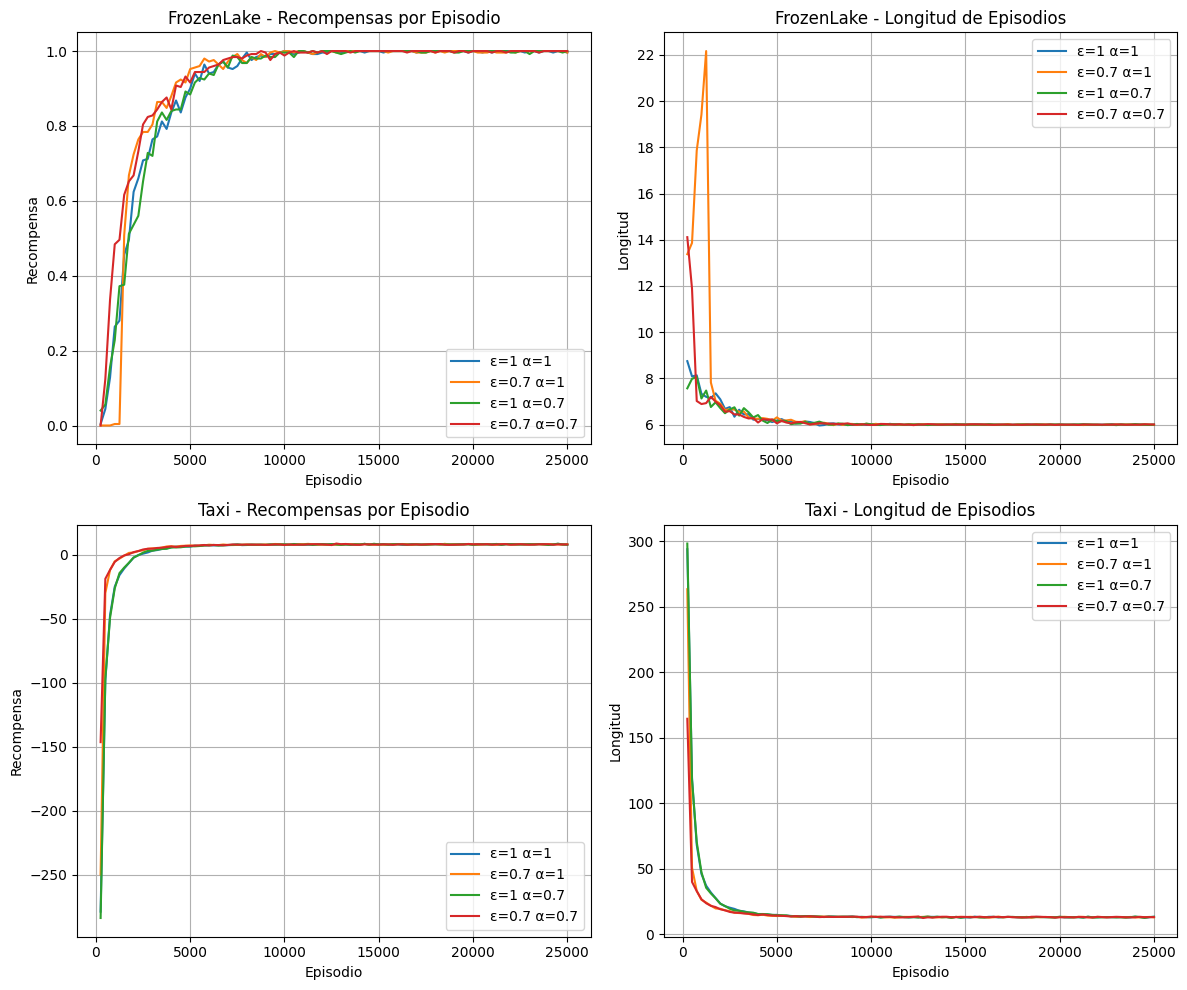

In [10]:
import matplotlib.pyplot as plt

n_media=250

# Agrupar estadísticas por environment
env_stats = {}
for entry in stats_list:
    env_name = entry["environment"]
    if env_name not in env_stats:
        env_stats[env_name] = []
    env_stats[env_name].append(entry)  # Guardamos todas las configuraciones de epsilon/alpha

# Crear subplots dinámicos según el número de entornos
num_envs = len(env_stats)
fig, axes = plt.subplots(num_envs, 2, figsize=(12, 5 * num_envs))  # (filas, columnas)

# Si solo hay un entorno, convertir `axes` en una lista para evitar errores de indexación
if num_envs == 1:
    axes = [axes]

# Generar gráficos por cada entorno
for idx, (env_name, env_entries) in enumerate(env_stats.items()):
    ax1, ax2 = axes[idx]  # Obtener los ejes de la fila correspondiente

    # Primera columna: Recompensas por episodio
    plt.sca(ax1)  # Establecer el eje activo en ax1
    for entry in env_entries:
        label = f"ε={entry['epsilon']} α={entry['alpha']}"
        plot_episode_rewards_subplot(entry["stats"]["episode_rewards"], n_media=n_media, ax=ax1)  # Usar tu función
    ax1.set_title(f"{env_name} - Recompensas por Episodio")
    ax1.set_xlabel("Episodio")
    ax1.set_ylabel("Recompensa")
    ax1.legend([f"ε={e['epsilon']} α={e['alpha']}" for e in env_entries])  # Leyenda con α y ε

    # Segunda columna: Longitud de episodios
    plt.sca(ax2)  # Establecer el eje activo en ax2
    for entry in env_entries:
        plot_len_episodes_subplot(entry["stats"]["episodes"], n_media=n_media, ax=ax2)  # Usar tu función
    ax2.set_title(f"{env_name} - Longitud de Episodios")
    ax2.set_xlabel("Episodio")
    ax2.set_ylabel("Longitud")
    ax2.legend([f"ε={e['epsilon']} α={e['alpha']}" for e in env_entries])  # Leyenda con α y ε

# Ajustar el espacio entre subplots
plt.tight_layout()
plt.show()


#### Análisis de los Resultados en Taxi y FrozenLake

En este experimento, el agente aprende utilizando Q-Learning, un método basado en aprendizaje por refuerzo, en los entornos Taxi y FrozenLake. Se probaron diferentes combinaciones de ε (exploración) y α (tasa de aprendizaje) para ver cómo afectan el desempeño del agente.
##### Entorno FrozenLake

##### Recompensas por episodio
- Todas las configuraciones llegan a recompensas cercanas a 1, lo que indica que el agente está aprendiendo bien a moverse en el lago sin caer en los agujeros. La diferencia entre las configuraciones es mínima, ya que todas alcanzan el máximo rendimiento casi al mismo tiempo.

##### Longitud de episodios
- Inicialmente, la configuración ε=0.7, α=1 (naranja) tiene episodios más largos que coincide con recompensa baja aun asi todas las configuraciones convergen hacia episodios cortos y recompensas altas a lo largo del tiempo.

##### Entorno Taxi
##### Recompensas por episodio
Como se esperaba, todas las configuraciones de Q-Learning hacen que la recompensa promedio se acerque a 0 y las diferencias entre ellas son mínimas, lo que indica que el agente está resolviendo bien la tarea.
##### Longitud de episodios
Al inicio, los episodios son largos, pero rápidamente se acortan y se estabilizan en todas las configuraciones.
Esto indica que el agente aprende rápido la mejor estrategia y la aplica de forma consistente.

##### Conclusión

- Q-Learning aprende rápido y de manera estable en ambos entornos.
- En FrozenLake y Taxi, el algoritmo encuentra la solución rápidamente en todas sus configuraciones.
- Al ser una Off-policy, la actualización de valores Q siempre se hace considerando la acción óptima aunque tenga un ε.


### Comparación entre los distintos algoritmos

Una vez estudiado cada uno de los algoritmos, los compararemos entre ellos para ver cual es el que se comporta mejor entre ellos. Para ello selecionaremos para cada algoritmo aquellos que han obtenido mejor resultado.

In [11]:
# Definir los valores de alpha y epsilon
alpha_values = [0.7]  # Menos agresivo y más agresivo
epsilon_values = [0.7]  # Menos explorador y más explorador

# Definir los entornos y sus nombres
environments = {
    "FrozenLake": env_frozen_lake,
    "Taxi": env_taxi
}

# Crear los agentes y almacenar metadatos
agents_info = []

for env_name, env in environments.items():
    for alpha in alpha_values:
        for epsilon in epsilon_values:
            agent_qlearning = QLearningEpsilonGreedyAgent(
                env,
                epsilon=epsilon,
                gamma=0.99,
                alpha=alpha,
                epsilon_decay=0.9995,
                alpha_decay=0.9995,
                min_epsilon=0.001,
                min_alpha=0.001
            )
            agent_sarsa = SarsaEpsilonGreedyAgent(
                    env,
                    epsilon=epsilon,
                    gamma=0.99,
                    alpha=alpha,
                    epsilon_decay=0.9995,
                    alpha_decay=0.9995,
                    min_epsilon=0.001,
                    min_alpha=0.001)
            agent_montecarlo = MonteCarloEpsilonGreedyAgent(env, epsilon=0.3, epsilon_decay=1)

            agents_info.append({
                "agent": agent_montecarlo,
                "environment": env_name,
                "epsilon": epsilon,
                "name":'MonteCarloEpsilonGreedyAgent'
            })
            agents_info.append({
                "agent": agent_sarsa,
                "environment": env_name,
                "alpha": alpha,
                "epsilon": epsilon,
                "name":'SarsaEpsilonGreedyAgent'
            })
            agents_info.append({
                "agent": agent_qlearning,
                "environment": env_name,
                "alpha": alpha,
                "epsilon": epsilon,
                "name":'QLearningEpsilonGreedyAgent'
            })

# Entrenar a los agentes y registrar estadísticas
stats_list = []

for info in agents_info:
    agent = info["agent"]
    agent.train(N_EPISODES, render_interval=500, video_path='videos')

    # Guardar estadísticas con el metadata asociado
    if "alpha" not in info:
        stats_list.append({
            "name":info['name'],
            "environment": info["environment"],
            "epsilon": info["epsilon"],
            "stats": agent.stats()
        })
    else:
        stats_list.append({
            "name":info['name'],
            "environment": info["environment"],
            "alpha": info["alpha"],
            "epsilon": info["epsilon"],
            "stats": agent.stats()
        })


100%|██████████| 25000/25000 [01:06<00:00, 374.75it/s]


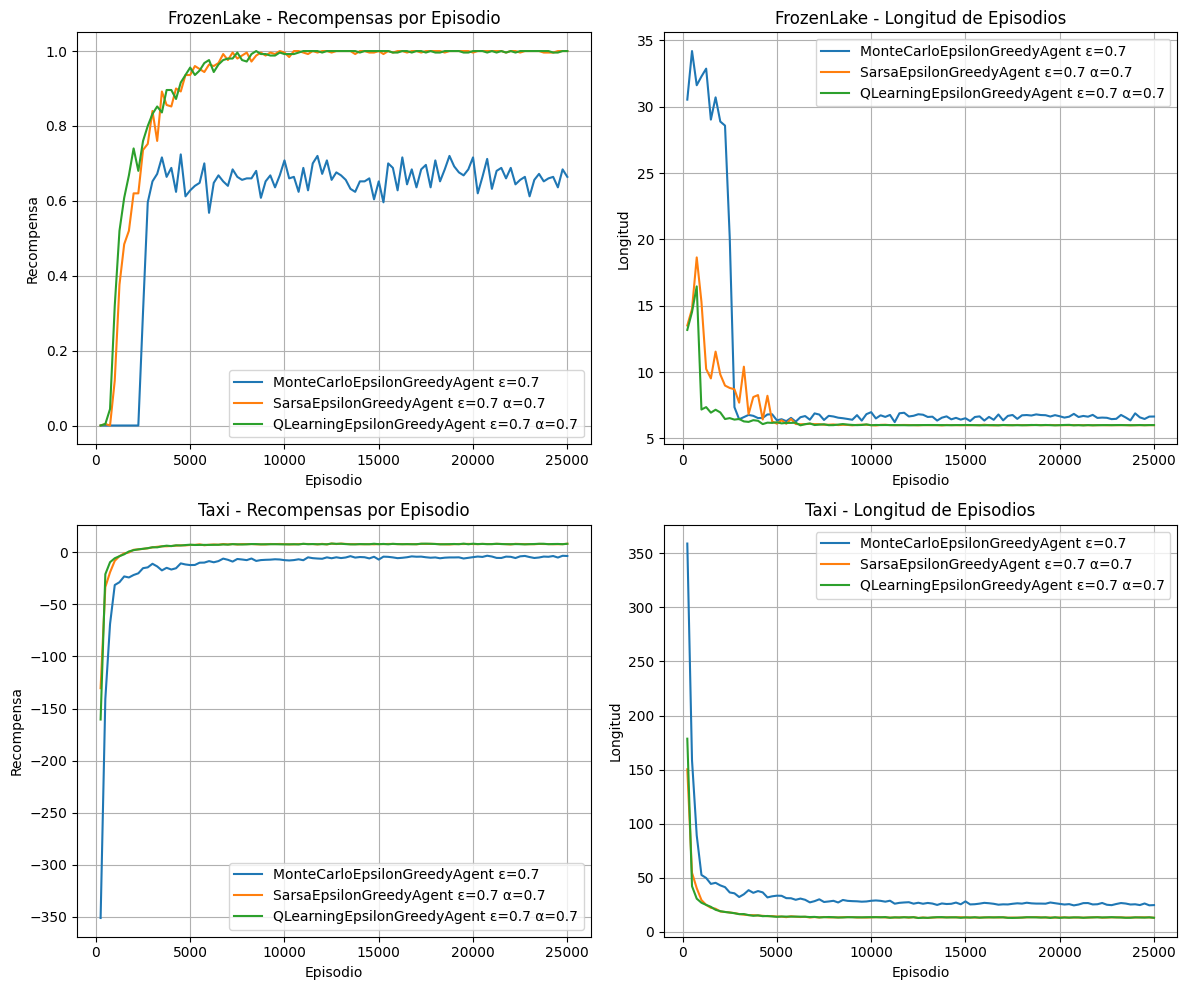

In [12]:
import matplotlib.pyplot as plt

n_media=250

# Agrupar estadísticas por environment
env_stats = {}
for entry in stats_list:
    env_name = entry["environment"]
    if env_name not in env_stats:
        env_stats[env_name] = []
    env_stats[env_name].append(entry)  # Guardamos todas las configuraciones de epsilon/alpha

# Crear subplots dinámicos según el número de entornos
num_envs = len(env_stats)
fig, axes = plt.subplots(num_envs, 2, figsize=(12, 5 * num_envs))  # (filas, columnas)

# Si solo hay un entorno, convertir `axes` en una lista para evitar errores de indexación
if num_envs == 1:
    axes = [axes]

# Generar gráficos por cada entorno
for idx, (env_name, env_entries) in enumerate(env_stats.items()):
    ax1, ax2 = axes[idx]  # Obtener los ejes de la fila correspondiente

    # Primera columna: Recompensas por episodio
    plt.sca(ax1)  # Establecer el eje activo en ax1
    for entry in env_entries:

        plot_episode_rewards_subplot(entry["stats"]["episode_rewards"], n_media=n_media, ax=ax1)  # Usar tu función
    ax1.set_title(f"{env_name} - Recompensas por Episodio")
    ax1.set_xlabel("Episodio")
    ax1.set_ylabel("Recompensa")
    ax1.legend([f"{e['name']} ε={e['epsilon']} α={e['alpha']}" if 'alpha' in e else f"{e['name']} ε={e['epsilon']}" for e in env_entries])  # Leyenda con α y ε

    # Segunda columna: Longitud de episodios
    plt.sca(ax2)  # Establecer el eje activo en ax2
    for entry in env_entries:
        plot_len_episodes_subplot(entry["stats"]["episodes"], n_media=n_media, ax=ax2)  # Usar tu función
    ax2.set_title(f"{env_name} - Longitud de Episodios")
    ax2.set_xlabel("Episodio")
    ax2.set_ylabel("Longitud")
    ax2.legend([f"{e['name']} ε={e['epsilon']} α={e['alpha']}" if 'alpha' in e else f"{e['name']} ε={e['epsilon']}" for e in env_entries])  # Leyenda con α y ε

# Ajustar el espacio entre subplots
plt.tight_layout()
plt.show()


#### Monte Carlo (Azul) vs SARSA (Naranja) vs Q-Learning (Verde)

#### FrozenLake
#### Recompensas por Episodio

- **Monte Carlo (azul)** muestra un comportamiento más inestable en comparación con SARSA y Q-Learning.
- **SARSA (naranja) y Q-Learning (verde)** convergen más rápido y alcanzan una recompensa promedio más alta.
- Monte Carlo no parece mejorar tanto como los otros dos métodos, lo que sugiere que podría necesitar más episodios para converger.
- Q-Learning converge mas rápido que SARSA en los primeros capítulos.

#### Longitud de Episodios
- **Monte Carlo (azul)** comienza con episodios más largos y tarda más en estabilizarse.
- **SARSA (naranja) y Q-Learning (verde)** reducen la longitud de los episodios más rápido junto a un aumento de la media obtenida de recompensa lo que indica que los agentes están encontrando soluciones óptimas.

#### Taxi
#### Recompensas por Episodio

- **Monte Carlo (azul)** muestra una curva de aprendizaje más lenta, con valores negativos por más tiempo.
- **SARSA (naranja) y Q-Learning (verde)** mejoran más rápido en comparación.
- Esto indica que **Monte Carlo tiene más dificultad para aprender en el entorno Taxi**.

#### Longitud de Episodios
- **Monte Carlo (azul)** empieza con episodios mucho más largos.
- **SARSA (naranja) y Q-Learning (verde)** reducen rápidamente la longitud de los episodios, lo que sugiere que aprenden una estrategia eficiente más rápido.

#### Conclusiones finales
- **Q-Learning (verde) es el más eficiente en FrozenLake**, logrando una convergencia más rápida y estable aunque **SARSA** tiene un comportamiento muy similar.
- **Monte Carlo (azul) tiene un desempeño inferior en ambos casos**, sin llegar a los niveles optimos de Q-Learning y Sarsa.
